In [337]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt

import arviz as az

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

<Axes: xlabel='Date_Symptoms'>

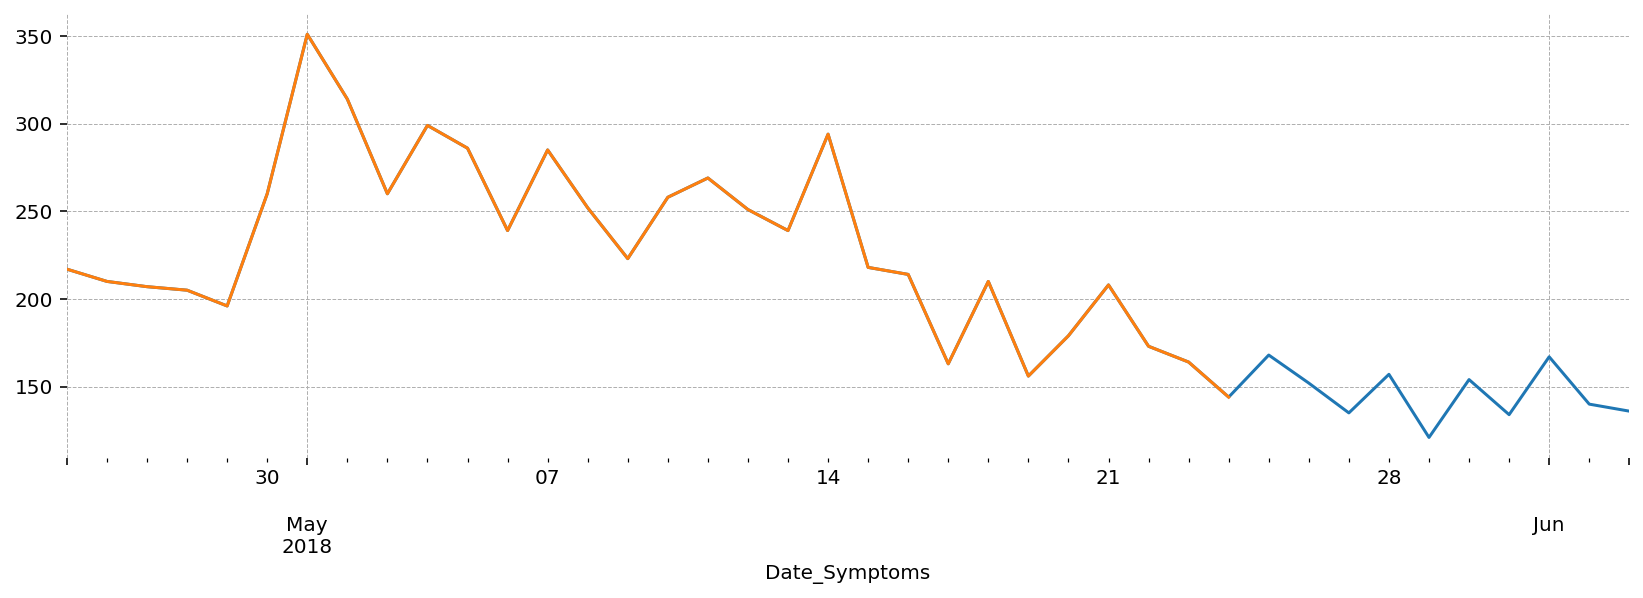

In [338]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 1900
M = 30
D = 10

y = train_df.sum(axis=1)[start_index: start_index + M + D]
y.index = pd.to_datetime(y.index)
y.index.freq = y.index.inferred_freq

y_train = y[:-D]
y.plot()
y_train.plot()

In [339]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, n_fourier=6, p=365.25):
    X = create_fourier_features(t, n_fourier, p)
    
    return X


In [340]:
t = np.arange(y.shape[0])
t_max = max(t)
with pm.Model() as model:
    t_pt = pm.MutableData('t', t[:-D])
    X_short = pm.Deterministic("X_short", generate_features(t_pt, n_fourier=2, p=7))
    X_long = generate_features(t_pt, n_fourier=2, p=3.5)
    
    slope = pm.Normal('slope', 0, 1)
    intercept = pm.Normal('intercept', 100, 100)
    
    # n_fourier * 2 seasonal coefficients
    beta_short = pm.Normal('beta_short', mu=5, sigma=20, size=X_short.shape[1])
    beta_long = pm.Normal('beta_long', mu=5, sigma=20,size=X_long.shape[1])
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt + X_short @ beta_short + X_long @ beta_long)
    sigma = pm.Exponential('sigma', 2)
    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_train, shape=t_pt.shape)
    
    idata = pm.sample()

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, beta_short, beta_long, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [341]:
with model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    pm.set_data({'t':t[-D:]})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

Sampling: [beta_long, beta_short, y_hat]


Output()

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_39236/2035844228.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim_name = list(idata.observed_data.dims.keys())[0]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_39236/2035844228.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  H = list(idata.predictions.dims.values())[-1]
<frozen _collections_abc>:913: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names

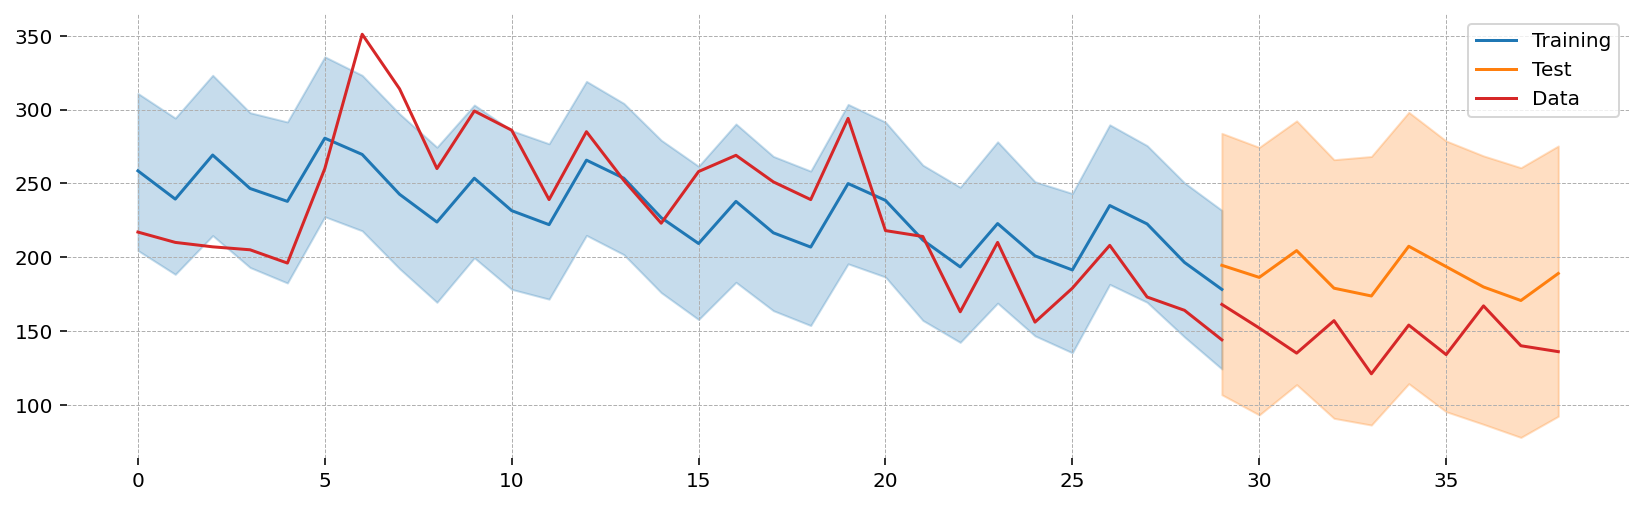

In [342]:
plot_results(idata, y[-D:])